# Pré-processamento

In [1]:
from tensorflow.keras import datasets
import numpy as np
# os rótulos não são necessários
(x_train, _), (x_test, _) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# concatenação dos dados (treino + teste)
dataset = np.concatenate([x_train, x_test], axis=0)
# normalização
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

# Montagem do modelo

Camada de amostragem

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Encoder

In [4]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))

x = Sequential([layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"),
                layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
                layers.Flatten(),
                layers.Dense(16, activation="relu")])
x = x(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16)        │     69,008 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [5]:
x = Sequential([layers.Dense(7 * 7 * 64, activation="relu"),
               layers.Reshape((7, 7, 64)),
               layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
               layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")])

latent_inputs = keras.Input(shape=(latent_dim,))
x = x(latent_inputs)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 32)     │        64,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

Estruturando uma classe para tornar o VAE funcional

In [6]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.total_loss = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
      self.total_loss,
      self.reconstruction_loss,
      self.kl_loss,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)

      # cálculo das métricas de perda
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2),))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss

    # atualização dos pesos
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    # atualização das métricas de perda
    self.total_loss.update_state(total_loss)
    self.reconstruction_loss.update_state(reconstruction_loss)
    self.kl_loss.update_state(kl_loss)

    return {
      "loss": self.total_loss.result(),
      "reconstruction_loss": self.reconstruction_loss.result(),
      "kl_loss": self.kl_loss.result(),
    }

# Treinamento

In [7]:
epochs, batch_size = 32, 128
# objeto dataset do tensotflow
tf_dataset = tf.data.Dataset.from_tensor_slices(dataset)
# embaralhamento e pré-carregamento dos dados
tf_dataset = tf_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(tf_dataset, epochs=epochs)

Epoch 1/32


I0000 00:00:1729717098.645686      98 service.cc:145] XLA service 0x58c66a053d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729717098.645733      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729717098.645737      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 29/547 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 2.6691 - loss: 476.4349 - reconstruction_loss: 473.7659

I0000 00:00:1729717102.781026      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - kl_loss: 2.7122 - loss: 252.8455 - reconstruction_loss: 250.1333
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.1689 - loss: 181.8792 - reconstruction_loss: 176.7103
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.6216 - loss: 167.8352 - reconstruction_loss: 162.2136
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.8992 - loss: 162.3649 - reconstruction_loss: 156.4657
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0993 - loss: 159.5005 - reconstruction_loss: 153.4012
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.2269 - loss: 157.5191 - reconstruction_loss: 151.2922
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.3105 - loss: 156.0163 - reconstruction_loss: 149.7057
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.3568 - loss: 155.0476 - reconstruction_loss: 148.6908
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_

# Visualização dos resultados

Valor das métricas ao longo do treinamento

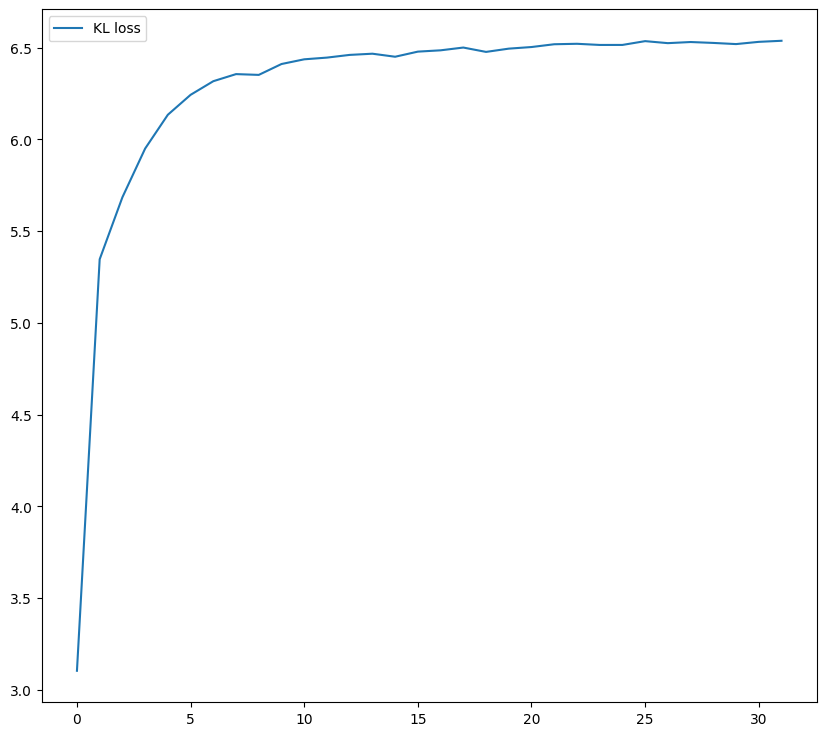

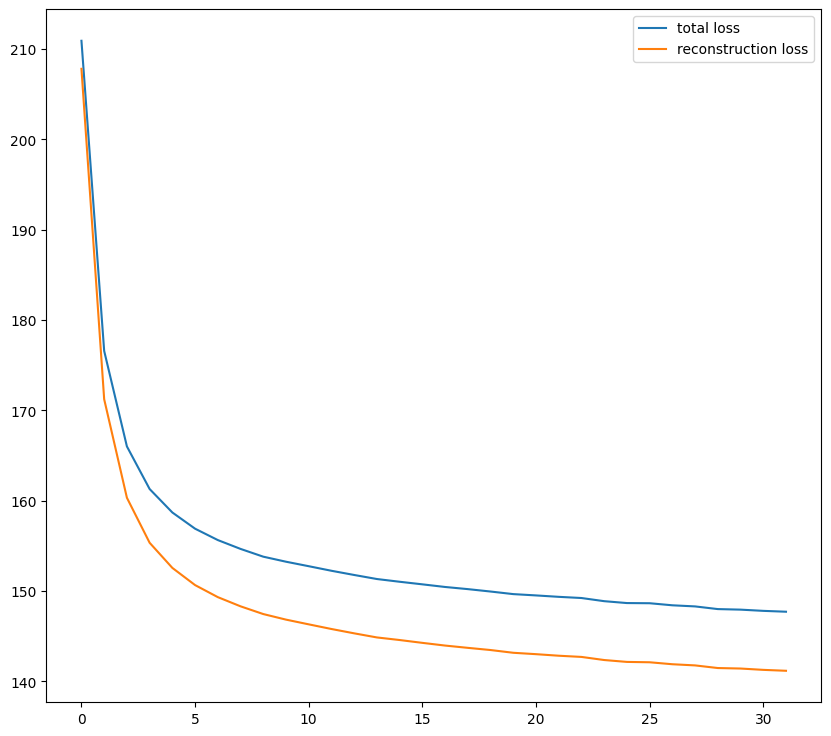

In [20]:
import matplotlib.pyplot as plt

# kl_loss
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend()

# Ênfase na reconstrução
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('loss'), label="total loss")
plt.plot(history.history.get('reconstruction_loss'), label="reconstruction loss")
plt.legend()

Visualização das imagem (originais e sintéticas)



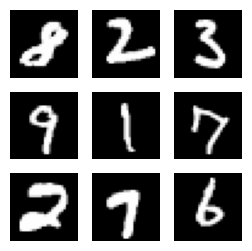

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


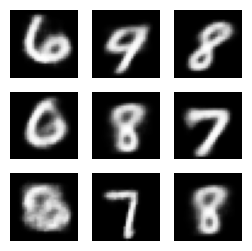

In [21]:
from matplotlib import pyplot as plt

# Amostragem das imagens originais
plt.figure(figsize=(3, 3))
rndSamples = np.random.choice(60000, 12)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
  plt.axis('off')

plt.show();

# Amostragem das imagens sintéticas
plt.figure(figsize=(3, 3))
rndSamples = np.random.choice(60000, 12)
for i in range(9):
  noise = np.random.normal(size=(1, 2))
  synth = vae.decoder.predict([noise])
  plt.subplot(3,3,i+1)
  plt.imshow(synth.reshape(28, 28), cmap="Greys_r")
  plt.axis('off')
plt.show();

# Criação de um novo Dataset sintético

In [ ]:
images_num = 10000
synth_dataset = np.array([])

while(len(synth_dataset) < images_num):
  noise = np.random.normal(size=(1, 2))
  synth = vae.decoder.predict([noise])
  synth_dataset = np.concatenate([synth_dataset, synth]) if synth_dataset.size else synth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

Amostragem do dataset

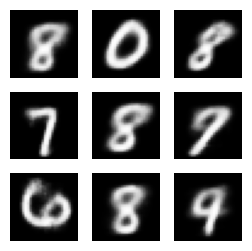

In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3, 3))

rndSamples = np.random.choice(10000, 12)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(synth_dataset[rndSamples[i]], cmap="Greys_r")
  plt.axis('off')

plt.show();

# Treinando outro VAE com o novo dataset

Concatenando os dois datasets (original + sintetico)



In [15]:
new_dataset = np.concatenate([dataset, synth_dataset])

In [16]:
epochs, batch_size = 32, 256
new_dataset = tf.data.Dataset.from_tensor_slices(new_dataset)
# embaralhamento e pré-carregamento dos dados
new_dataset = new_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
new_vae = VAE(encoder, decoder)
new_vae.compile(optimizer=keras.optimizers.Adam())
new_history = new_vae.fit(new_dataset, epochs=epochs)

Epoch 1/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - kl_loss: 6.5248 - loss: 147.5968 - reconstruction_loss: 141.0720
Epoch 2/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5427 - loss: 147.8156 - reconstruction_loss: 141.2729
Epoch 3/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5472 - loss: 147.7542 - reconstruction_loss: 141.2069
Epoch 4/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5493 - loss: 147.4760 - reconstruction_loss: 140.9266
Epoch 5/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5275 - loss: 147.4137 - reconstruction_loss: 140.8862
Epoch 6/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5399 - loss: 147.2091 - reconstruction_loss: 140.6692
Epoch 7/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5331 - loss: 146.8984 - reconstruction_loss: 140.3653
Epoch 8/32
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 6.5502 - loss: 146.7828 - reconstruction_loss: 140.2325
Epoch 9/32
313/313 ━━━━━━━━━━━━━━━━━━━━

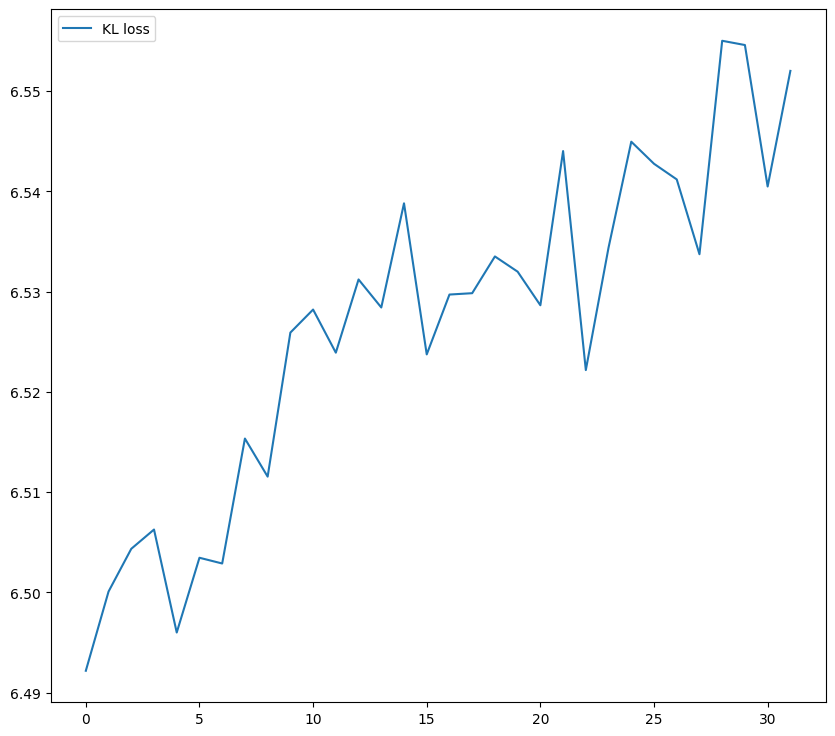

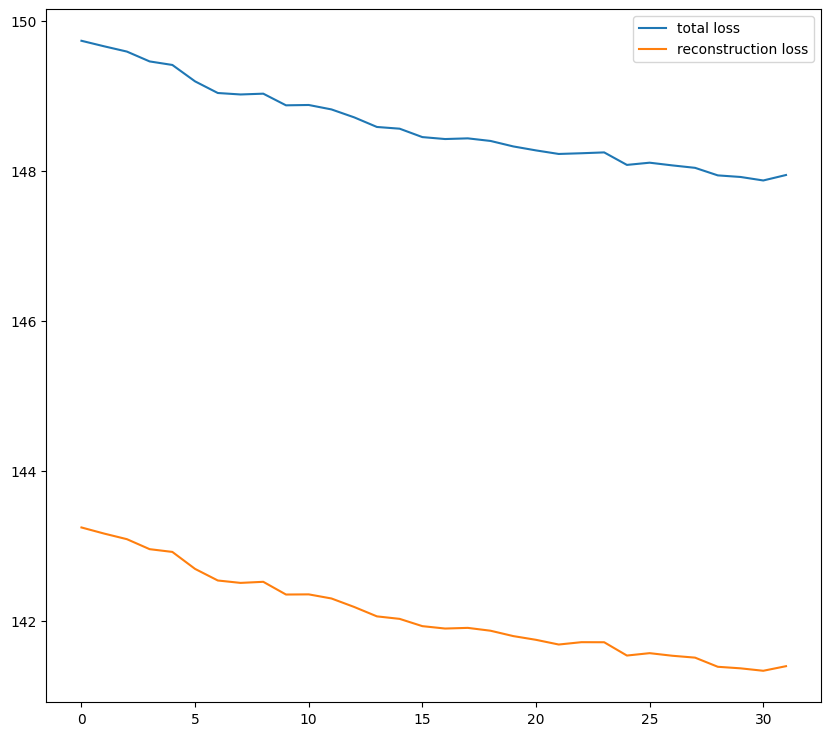

In [18]:
import matplotlib.pyplot as plt

# kl_loss
plt.figure(figsize=(10, 9))
plt.plot(new_history.history.get('kl_loss'), label="KL loss")
plt.legend()

# Ênfase na reconstrução
plt.figure(figsize=(10, 9))
plt.plot(new_history.history.get('loss'), label="total loss")
plt.plot(new_history.history.get('reconstruction_loss'), label="reconstruction loss")
plt.legend()

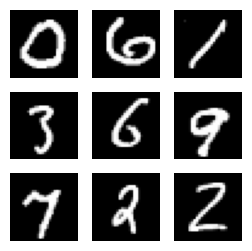

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


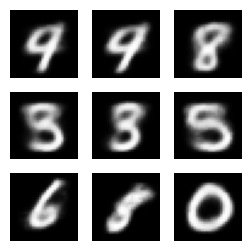

In [22]:
from matplotlib import pyplot as plt

# Amostragem das imagens originais
plt.figure(figsize=(3, 3))
rndSamples = np.random.choice(60000, 12)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
  plt.axis('off')

plt.show();

# Amostragem das imagens sintéticas
plt.figure(figsize=(3, 3))
rndSamples = np.random.choice(60000, 12)
for i in range(9):
  noise = np.random.normal(size=(1, 2))
  synth = vae.decoder.predict([noise])
  plt.subplot(3,3,i+1)
  plt.imshow(synth.reshape(28, 28), cmap="Greys_r")
  plt.axis('off')
plt.show();